# "ISL-Chapter-01 (Interactive Learning)"
> "Chapter 01 - Introduction to Statistical Learning"

- toc: True
- branch: master
- badges: true
- comments: true
- categories: [jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true

**Note**: The content of this post is based on my understanding from Chapter 01 of the book [Introduction to Statistical Learning](https://www.statlearning.com/). If you haven't read this chapter from the book, I recommend reading it first (Its online version is available for free. You can find it via the provided link.) 

Feel free to change the code and see how the results behave. You may find something interesting. We have used `panel` to create interactive plots through which you can easily try different scenarios and see their corresponding outcomes!

In Chapter 01, the authors show three data sets that will be used throughout the book. In this notebook, we will go through those three data sets. Please feel free and play around the code  to make yourself familiar with them. If you are already familiar with the code, you can go through the material and the additional discussion provided to make the context richer...

## import libraries

In [1]:
import numpy as np
import pandas as pd

import panel as pn
import hvplot.pandas

import matplotlib.pyplot as plt

from collections import Counter 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Wage Data
**DATA Description: Income survey data for men in central Atlantic region of USA**

In [3]:
Wage = pd.read_csv("./datasets/Wage.csv")
Wage.head(5)

,ID,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


The ID data is useless here, so let us drop it...

In [4]:
df = Wage.drop(columns=['ID'])

Let us assume the goal is to predict `wage` based on the provided predictors. We should now seperate the feature data and response variable data:

In [5]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

Now, let us take a quick look at the summary of our feature data:

In [6]:
X.describe()

,year,age,logwage
count,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,4.653905
std,2.026167,11.542406,0.351753
min,2003.000000,18.000000,3.000000
25%,2004.000000,33.750000,4.447158
50%,2006.000000,42.000000,4.653213
75%,2008.000000,51.000000,4.857332
max,2009.000000,80.000000,5.763128


while `.describe()` method (on `DataFrame` object) is a good approach to see Summary statistics, it cannot show information for categorical features. So, we need to handle them seperately. We can notice a similar issue  when we `.hist()` to plot historgram of feature. See below:

In [24]:
def view_hvplot_hist(ps):
    return ps.hvplot.hist(height=300, width=400, legend=False)

def view_hvplot_bar(ps):
    cat_cnts = Counter(ps)
    df_cnts = pd.DataFrame({
        "categories":list(cat_cnts.keys()),
        "frequencies":list(cat_cnts.values())
    })
    return df_cnts.hvplot.bar(x="categories", y="frequencies", legend=False)


def plot_data(data, variable="year", view_fn=view_hvplot_hist):
    return view_fn(data[variable])

In [25]:
# plot_hist(df, variable="year")

pn.extension(design='material')
variable_widget = pn.widgets.Select(name="variable", value="year", options=["year","age", "logwage"])
bound_plot = pn.bind(plot_data, df, variable=variable_widget, view_fn=view_hvplot_hist)
Explore_data = pn.Column(variable_widget, bound_plot)

Explore_data

Column(design=<class 'panel.theme.materi...)
    [0] Select(design=<class 'panel.theme.materi..., name='variable', options=['year', 'age', ...], value='year')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False, design=<class 'panel.theme.materi...)

How about other features (predictors)? Let us see their plots...

In [26]:
#find categorical features

all_features = X.columns #find all features
num_features = X._get_numeric_data().columns #find numerical features
cat_features = list(set(all_features) - set(num_features)) #get non-numerical features!

print('categorical features are: \n', cat_features) 

categorical features are: 
 ['health_ins', 'education', 'region', 'maritl', 'race', 'jobclass', 'health', 'sex']


Neat! Now, let us find check them out:

In [27]:
# plot_hist(df, variable="year")

pn.extension(design='material')
cat_variable_widget = pn.widgets.Select(name="variable", value="health_ins", options=cat_features)
bound_plot = pn.bind(plot_data, df, variable=cat_variable_widget, view_fn=view_hvplot_bar)
Explore_cat_data = pn.Column(cat_variable_widget, bound_plot)

Explore_cat_data

Column(design=<class 'panel.theme.materi...)
    [0] Select(design=<class 'panel.theme.materi..., name='variable', options=['health_ins', ...], value='health_ins')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False, design=<class 'panel.theme.materi...)

**NOTE:** <br>
Please note that the two features "region" and "sex", each has one category. In other words, their values remain constant from one sample to the next. Therefore, they do not add extra information about Wage. These constant values can be filtered out throughout the data preprocessing stage. Let us clean it (We will not change the file of data. The following is just to show how to perform such preprocessing)

In [28]:
def get_constant_features(X, constant_percentage = 0.95):
    """
    this function takes a dataframe X and returns the features where the feature is almost constant. 
    If the most frequent value appears in at least `constant_percentage` of samples, we treat is as constant.
    
    Parameters
    ---------
    X : DataFrame
        a dataframe of size (m, n) where m is the number of observations and n is the number of features
    
    constant_percentage : float
        a scalar value between 0 and 1, acts as the threshold below which the feature is considered to be not constant.
    
    Returns
    ---------
    constant_features : list
        list of names of features that are constant
    """
    n_samples = X.shape[0]
    
    constant_features = []
    for feature in X.columns:
        counts = list(Counter(X[feature]).values())    
        if np.max(counts)/n_samples >= constant_percentage:
            constant_features.append(feature)
    
    return constant_features

In [29]:
#now let us see if it works...
constant_features = get_constant_features(X)
constant_features

['sex', 'region']

Cool! let us drop them :)

In [30]:
X_clean = X.drop(columns=constant_features)
X_clean.head(3)

,year,age,maritl,race,education,jobclass,health,health_ins,logwage
0,2006,18,1. Never Married,1. White,1. < HS Grad,1. Industrial,1. <=Good,2. No,4.318063
1,2004,24,1. Never Married,1. White,4. College Grad,2. Information,2. >=Very Good,2. No,4.255273
2,2003,45,2. Married,1. White,3. Some College,1. Industrial,1. <=Good,1. Yes,4.875061


Note that we abused the word `clean` here as we **only** dropped the constant features. However, the term `clean` may mean handling missing data and/or outliers in other context. For now, we are going to use `X_clean` in this notebook.

Ok! Now, let us reproduce some of the figures of the book. "year" and "age" are  both continuous features. It is interesting to see how the target `wage` changes with respect to those features

In [42]:
def view_hvplot_feature_and_target(X_1d, y):
    # X_1d is ps, representing one feature
    # y is the target
    df = pd.concat([X_1d, y], axis=1)
    df.columns = ['feature', 'target']
    y_avg = y.groupby(X_1d).mean()
    
    return df.hvplot.scatter(x='feature', y='target', height=300, width=400, legend=False, color='b') * y_avg.hvplot(color='r', legend=False)


def plot_data_feature_vs_target(data, target_value, feature_variable="year", view_fn=view_hvplot_feature_and_target):
    return view_fn(data[feature_variable], target_value)


pn.extension(design='material')
variable_to_analyze_widget = pn.widgets.Select(name="feature_variable", value="age", options=["age", "year"])
bound_plot = pn.bind(plot_data_feature_vs_target, df, y, feature_variable=variable_to_analyze_widget, view_fn=view_hvplot_feature_and_target)
Explore_feature_target = pn.Column(variable_to_analyze_widget, bound_plot)

Explore_feature_target

Column(design=<class 'panel.theme.materi...)
    [0] Select(design=<class 'panel.theme.materi..., name='feature_variable', options=['age', 'year'], value='age')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False, design=<class 'panel.theme.materi...)

**> Wage against categorical data**

In [46]:
def view_hvplot_data_explorer(df, feature_name, target_name):
    """
    Box-plot of `y` considering different categories in `X[feature]`
    """
    boxplot = df.hvplot.box(y=target_name, by=feature_name, height=400, width=600, legend=False)
    return boxplot


def plot_feature_target_relationship(df, feature_name, target_name='wage', view_fn=view_hvplot_data_explorer):
    return view_fn(df, feature_name, target_name)


pn.extension(design='material')
feature_widget = pn.widgets.Select(name="feature_name", value="education", options=cat_features)
bound_plot = pn.bind(plot_feature_target_relationship, df, feature_name=feature_widget)
feature_target_app = pn.Column(feature_widget, bound_plot)

feature_target_app

Column(design=<class 'panel.theme.materi...)
    [0] Select(design=<class 'panel.theme.materi..., name='feature_name', options=['health_ins', ...], value='education')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False, design=<class 'panel.theme.materi...)

## Stock Market Data
**Daily percentage returns for S&P 500 over a 5-year period** <br>
Since we already walked the reader through the steps of previous data set, we will avoid repeating ourself. We will show the codes and provide some explanations if necessary.

In [49]:
df = pd.read_csv("./datasets/Smarket.csv")
df = df.drop(columns=['ID']) #drop ID

df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


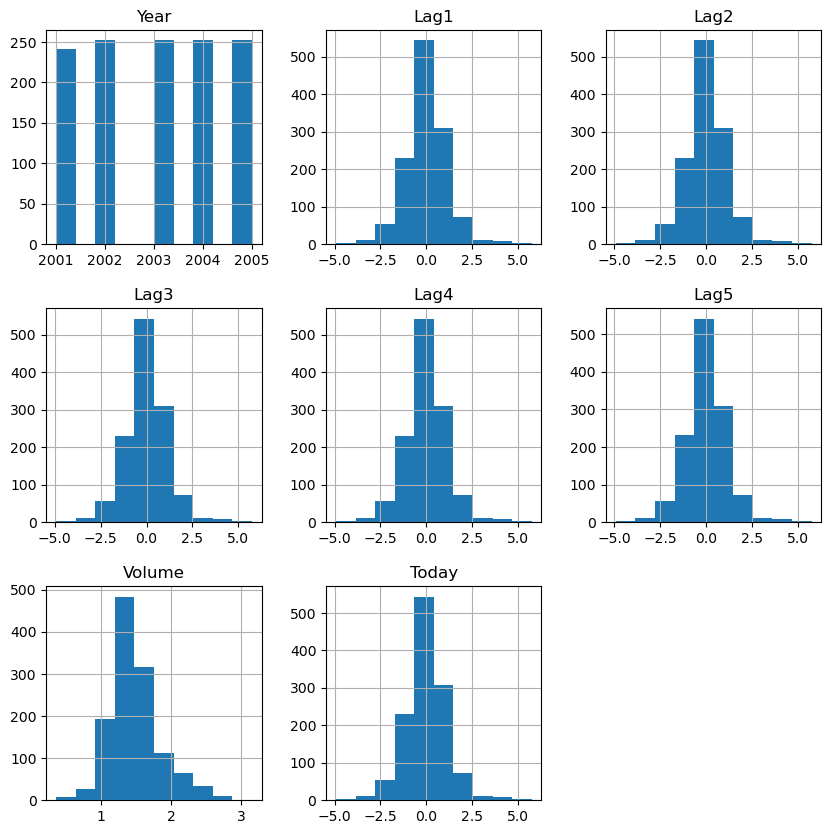

In [50]:
axs = df.hist(figsize=(10,10))

In [53]:
def view_hvplot(df, feature_name, target_name):
    """
    return hvplot
    """
    return df.hvplot.box(y=feature_name, by=target_name, height=400, width=400, legend=False)
    

    
def plot_feature_target_relationship(df, feature_name, target_name='Direction', view_fn=view_hvplot):
    return view_hvplot(df, feature_name, target_name)


pn.extension(design='material')
feature_widget = pn.widgets.Select(name="feature_name", value="Lag1", options=[f"Lag{i}" for i in range(1, 6)])
bound_plot = pn.bind(plot_feature_target_relationship, df, feature_name=feature_widget)
feature_target_app = pn.Column(feature_widget, bound_plot)

feature_target_app

Column(design=<class 'panel.theme.materi...)
    [0] Select(design=<class 'panel.theme.materi..., name='feature_name', options=['Lag1', 'Lag2', ...], value='Lag1')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False, design=<class 'panel.theme.materi...)

As illustrated, in each feature, the two boxplots are similar to each other. Therefore, each of these features should contribute a little (if any) to the prediction of the response variable `Direction`.

## Gene Expression Data

**NCI60: Gene expression measurements for 64 cancer cell lines**

In [66]:
df = pd.read_csv("./datasets/NCI60.csv", index_col = 0)
df.head()

,data.1,data.2,data.3,data.4,data.5,data.6,data.7,data.8,data.9,data.10,...,data.6822,data.6823,data.6824,data.6825,data.6826,data.6827,data.6828,data.6829,data.6830,labs
V1,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.450000,-0.654980,...,0.000000,0.030000,-0.175000,0.629981,-0.030000,0.000000,0.280000,-0.340000,-1.930000,CNS
V2,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.040039,-0.285019,...,-0.300039,-0.250039,-0.535039,0.109941,-0.860039,-1.250049,-0.770039,-0.390039,-2.000039,CNS
V3,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.430000,0.475019,...,0.120000,-0.740000,-0.595000,-0.270020,-0.150000,0.000000,-0.120000,-0.410000,0.000000,CNS
V4,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.020000,0.095019,...,-0.110000,-0.160000,0.095000,-0.350019,-0.300000,-1.150010,1.090000,-0.260000,-1.100000,RENAL
V5,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.235000,1.490019,...,-0.775000,-0.515000,-0.320000,0.634980,0.605000,0.000000,0.745000,0.425000,0.145000,BREAST


In [67]:
print('shape of df: ', df.shape)

shape of df:  (64, 6831)


I avoid plotting histogram of each feature here <br>
**NOTE:** <br>
For now, I will just use sklearn to apply PCA to the data and we will discuss PCA later. However, it might be a good idea to make yourself familiar with PCA... I think this [YouTube Video](https://www.youtube.com/watch?v=FgakZw6K1QQ) explains it well.

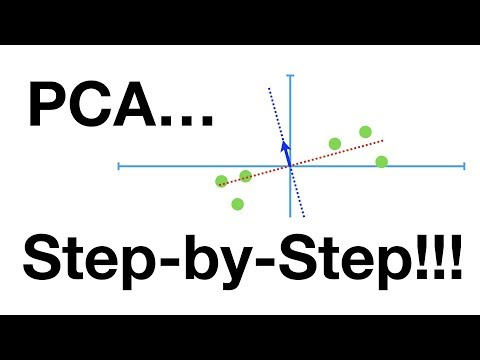

In [65]:
from IPython.display import YouTubeVideo

# a talk about IPython at Sage Days at U. Washington, Seattle.
# Video credit: William Stein.
YouTubeVideo('FgakZw6K1QQ', width=800, height=600)

In [68]:
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1] 
y_counts = Counter(y)
y_counts

Counter({'CNS': 5,
         'RENAL': 9,
         'BREAST': 7,
         'NSCLC': 9,
         'UNKNOWN': 1,
         'OVARIAN': 6,
         'MELANOMA': 8,
         'PROSTATE': 2,
         'LEUKEMIA': 6,
         'K562B-repro': 1,
         'K562A-repro': 1,
         'COLON': 7,
         'MCF7A-repro': 1,
         'MCF7D-repro': 1})

The last feature, `labs`, tells us that there are 14 groups in our data. We now try to visualize the 64-dim data. (You can color code the tags provided in the response variable, and color the data points accordingly)

In [69]:
#we need to standardize each feature before PCA (Why? answer provided below)
X = StandardScaler().fit_transform(X) 

pca = PCA(n_components=2).fit(X)
pca.explained_variance_ratio_

array([0.11358942, 0.06756202])

Have you noticed that we normalized the data before passing it to PCA? why should we normalize data before using PCA?? You can read about it below: <br>

* [StackOverFlow (I)](https://stats.stackexchange.com/questions/69157/why-do-we-need-to-normalize-data-before-principal-component-analysis-pca)
* [StackOverFlow (II)](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance) 

It seems the first two components can only explains about 18% of the variance. Let us not worry about that for now and just plot the data in 2D (just to see how it works)

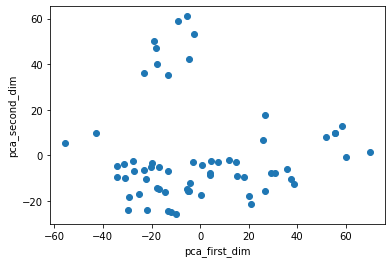

In [22]:
X_pca = pca.transform(X)

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.xlabel('pca_first_dim')
plt.ylabel('pca_second_dim')
plt.show()

And, that's it! We just plotted the 64-dim data in 2D space with help of PCA. One thing you may notice here is that the figure in the book is a little bit different. In fact, if you flip the signs of values of the second component of PCA, we will get the figure provided in the book! (I hope we can get some clarification from authors of the book in the nearby future! Or, maybe I made a mistake!! Did I???)

The other thing you may think about is that if PCA can preserve large relative distance among points. Because, if not, then we cannot trust the structures of points in 2D space. PCA can preserve the large pair-wise distances (see [StackOverFlow](https://stats.stackexchange.com/questions/176672/what-is-meant-by-pca-preserving-only-large-pairwise-distances)). So, it can help us understand the overal structure of groups in the data.

## Summary

* **Read .csv data:** `df = pd.read_csv(.., index_col = None)`

* **see data table:** `df.head()` --> **see shape:** `df.shape`



* **see distribution of numerical data:** `df.hist()` #see historgram of each numerical feature

* **count tags in categorical data:** `collections.Counter(X[cat_feature])`

* **get numerical data:** `df._get_numeric_data()`



* **Get X and y:** `X = df.iloc[:,:-1]; y = df.iloc[:,-1]` (if label is the last column and all other columns are features)



* **Take avg of y w.r.t values/tags in a feature:** `y.groupby(X[feature]).mean()`

* **create groups of observation w.r.t values/tags:** `groups = y.groups(X[feature])` --> `for i, (key, item) in enumerate(groups): ...`



* **Drop (almost) constant features:** use `collections.Counter()` to discover those features --> `df.drop(almost-constant features)`



* **relationship between a feature and y:** plot y-x (if y continuous) and if y is tags (e.g. yes/no), we can plot boxplot values of x of observations with response yes, and the boxplot of x of observations with respons no. 